**Imports**

In [1]:
%matplotlib inline

# Conda imports
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.ticker import PercentFormatter

# Local imports
import common
import helpers
import processing.statistics as statistics
from data import get_mnist, get_cifar
from processing.snapshots import Snapshots

## Loading a model

In [2]:
def results_path(output_dir, layers):
    fp_paths ={}
    ip_paths = {}
    norms_paths = {}
    for layer in layers:
        fp_paths[layer] = helpers.train_results_path(output_dir, common.FP_PREFIX, layer)
        ip_paths[layer] = helpers.train_results_path(output_dir, common.IP_PREFIX, layer)
        norms_paths[layer] = helpers.train_results_path(output_dir, common.NORM_PREFIX, layer)
        
    return fp_paths, ip_paths, norms_paths

In [3]:
conv2_output = "out/Conv2-28_11_2019-10:21:39"
conv2_layers = ["conv2", "fc1", "fc2"]
conv4_output = "out/Conv4-28_11_2019-18:17:15"
conv4_layers = ["conv4", "fc1", "fc2"]
conv6_output = "out/Conv6-28_11_2019-18:23:42"
conv6_layers = ["conv6", "fc1", "fc2"]

output_dir = conv2_output  # changeme
layers = conv2_layers  # changeme
fp_paths, ip_paths, norms_paths = results_path(output_dir, layers)

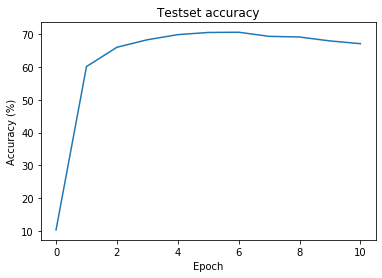

In [4]:
helpers.plot_test_acc(output_dir)

In [5]:
acc_path = os.path.join(output_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
test_accuracies = np.load(acc_path)
print("Best test accuracy at epoch N°", np.argmax(test_accuracies))

Best test accuracy at epoch N° 6


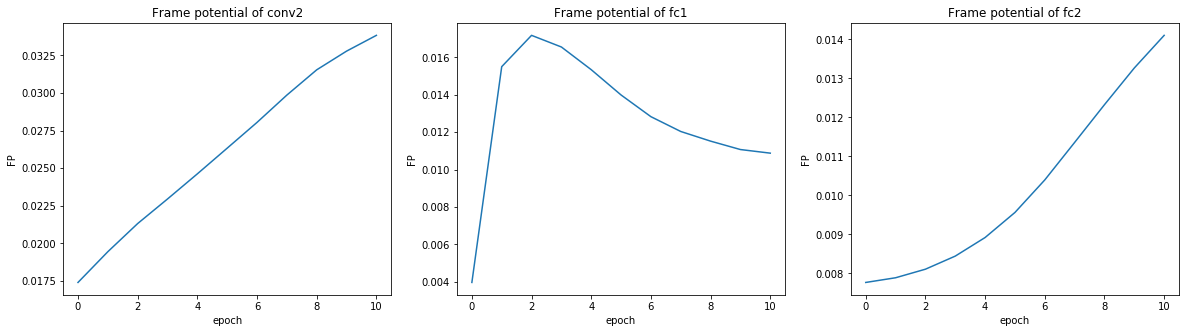

In [6]:
helpers.plot_train_fps(fp_paths, layers)

## Analysis of a layer

In [7]:
# Because of overfitting, we might want restrict the analysis to the first n epochs
epochs = np.argmax(test_accuracies) + 1
layer = "fc1"
weight_norms = np.load(norms_paths[layer])[:epochs]
s = Snapshots(output_dir)
weights = s.get_weights(layer)[:epochs]

### 1. Plot of L2-norm distribution

In [64]:
def norm_distribution(norms, epoch):
    fig, ax = plt.subplots(tight_layout=True)
    ax.hist(norms[epoch], bins=50)
    ax.set_xlabel("L2 norm of weight vector")
    ax.set_ylabel("Count")
    ax.set_title(f"Epoch {epoch} - L2-norm distribution")
    plt.show()

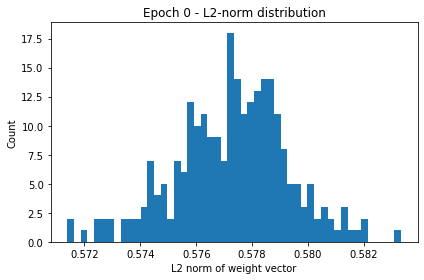

In [65]:
norm_distribution(weight_norms, 0)

In [66]:
def plot_training_norms(norms):
    epochs = norms.shape[0]
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(epochs):
        axs[epoch].hist(norms[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=norms.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of weight vector norms during training", fontsize=16)
    fig.text(0.5, 0.04, 'L2 norm of weight vector', ha='center')
    fig.text(0.04, 0.5, 'Fraction of weight vectors', va='center', rotation='vertical')

    plt.show()

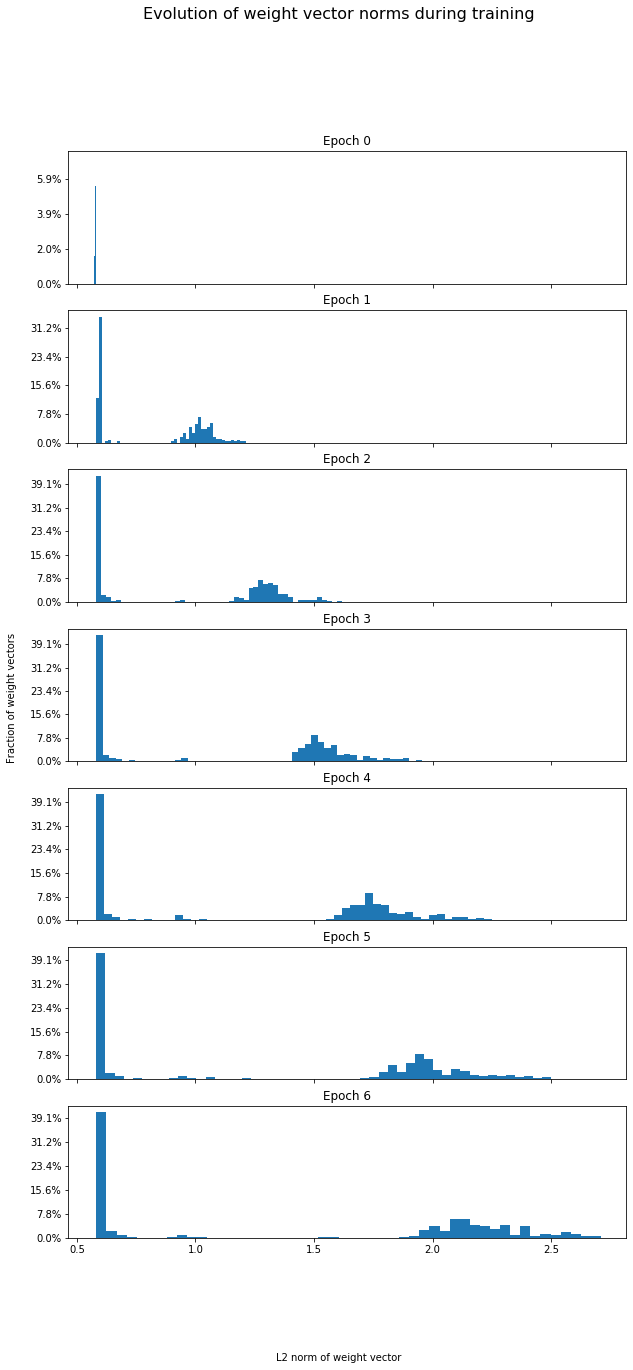

In [67]:
plot_training_norms(weight_norms)

In [62]:
def trained_vector_norms(norms, cut_off=0.8):
    final_norms = norms[-1]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(final_norms, bins=50)
    axs[0].set_xlabel("L2 norm of weight vector")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Trained weight vectors - L2-norm distribution")
    selected_norms = final_norms[final_norms < cut_off]
    hist = axs[1].hist(selected_norms, bins=50)
    axs[1].set_xlabel("L2 norm of weight vector")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Trained weight vectors - L2-norm distribution (subset)")
    plt.show()

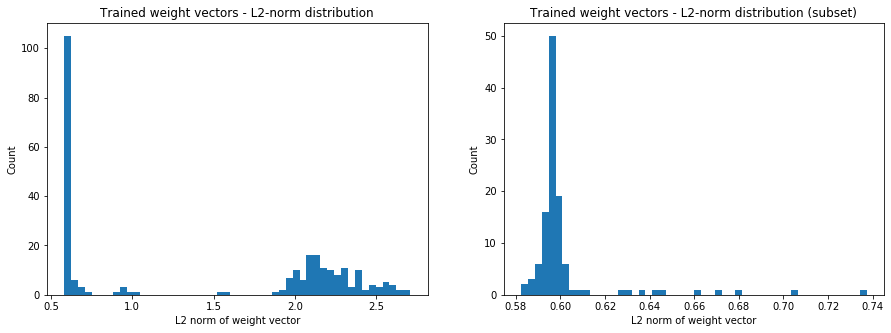

In [63]:
trained_vector_norms(weight_norms)

### 2. Analysis of space spanned by normalized weight vectors

In [11]:
w = torch.zeros(weights.shape)
# Normalize the weight vectors for every epoch
for epoch in range(epochs):
    w[epoch] = F.normalize(weights[epoch], p=2, dim=1)

In [12]:
def svd(selected_weights):
    u = np.zeros((epochs, selected_weights.shape[2], selected_weights.shape[1]))
    s = np.zeros((epochs, selected_weights.shape[1]))

    for epoch in range(epochs):
        # Look at space spanned by the rows of the weight matrix
        w_epoch = selected_weights[epoch].numpy().T
        u_epoch, s_epoch, _ = np.linalg.svd(w_epoch, full_matrices=False)
        u[epoch] = u_epoch
        s[epoch] = s_epoch
    
    return u, s

In [13]:
def singular_value_distribution(s):
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(epochs):
        axs[epoch].hist(s[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=s.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of singular values during training", fontsize=16)
    fig.text(0.5, 0.04, 'Value', ha='center')
    fig.text(0.04, 0.5, 'Fraction of singular values', va='center', rotation='vertical')

    plt.show()

In [14]:
def svd_comparison(s):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(s[0], bins=50)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Singular values distribution of untrained weight matrix")
    hist = axs[1].hist(s[-1], bins=50)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Singular values distribution of trained weight matrix")
    plt.show()

In [15]:
u_full, s_full = svd(w)

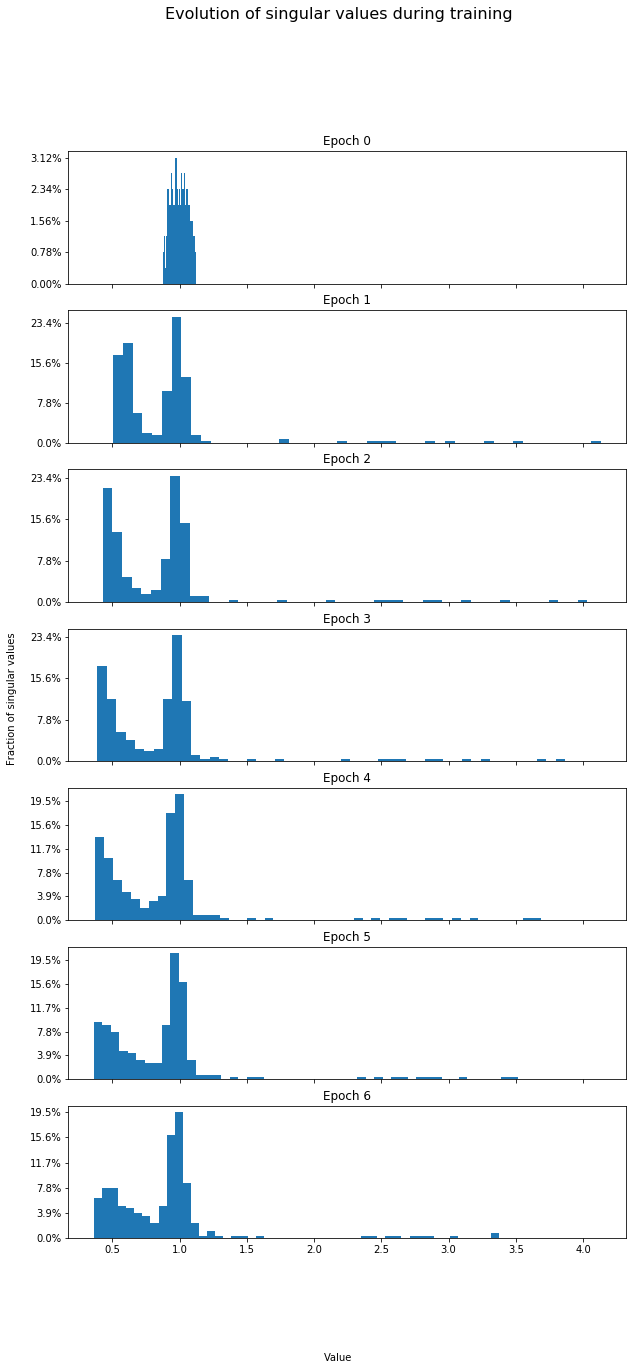

In [16]:
singular_value_distribution(s_full)

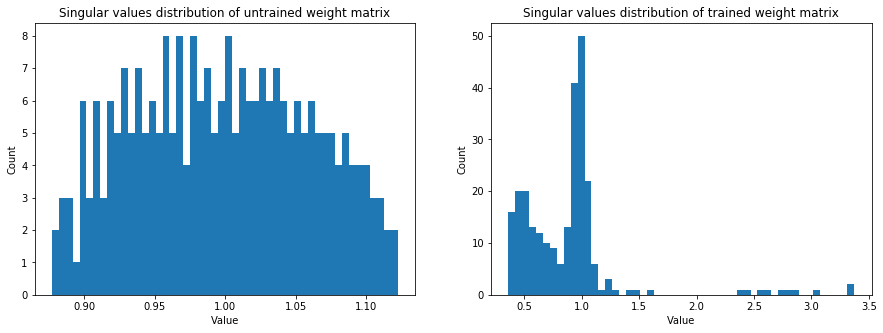

In [17]:
svd_comparison(s_full)

### 3. Looking at selected weight vectors

In [18]:
cutoff = 1.2
trained_neurons = (weight_norms[-1] > cutoff)
selected_neurons = np.argwhere(trained_neurons).flatten().tolist()
unselected_neurons = np.argwhere(~trained_neurons).flatten().tolist()

In [19]:
u_selected, s_selected = svd(w[:, selected_neurons, :])

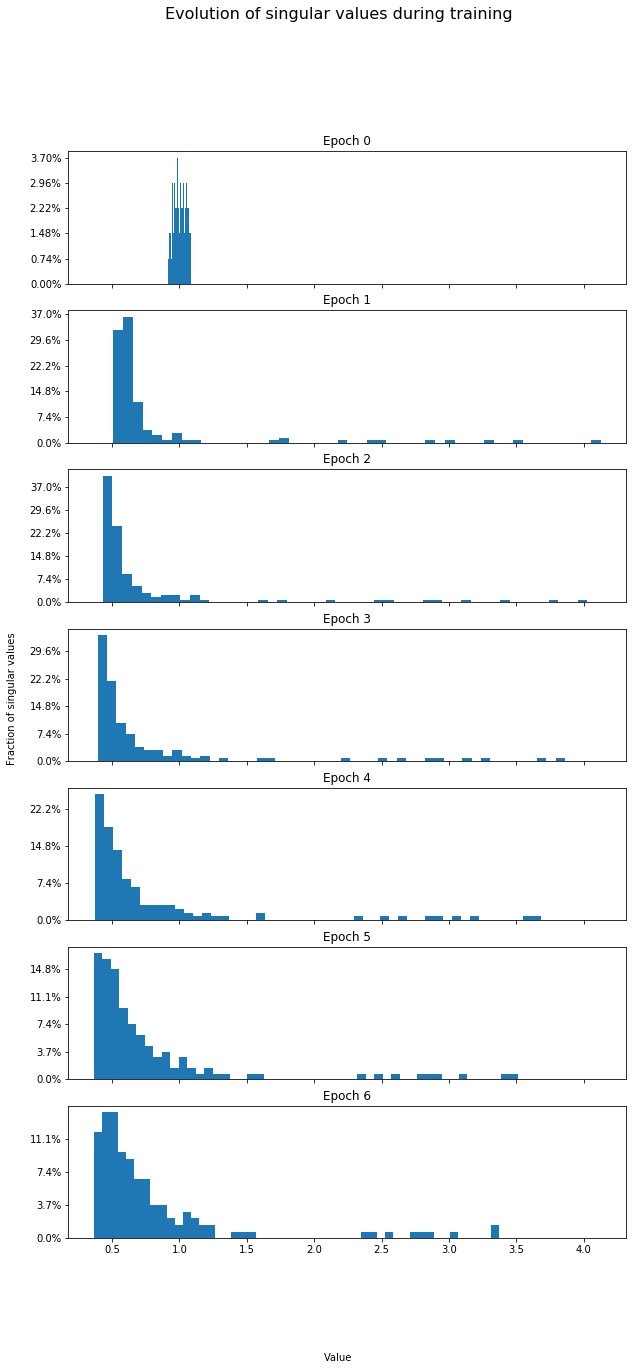

In [20]:
singular_value_distribution(s_selected)

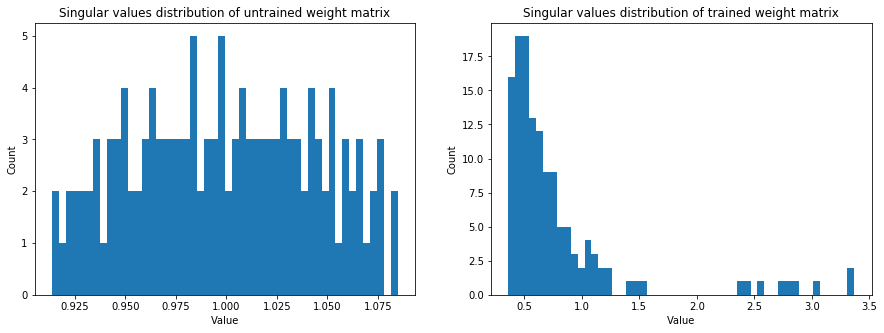

In [21]:
svd_comparison(s_selected)

### 4. Looking at unselected weight vectors

In [22]:
u_unselected, s_unselected = svd(w[:, unselected_neurons, :])

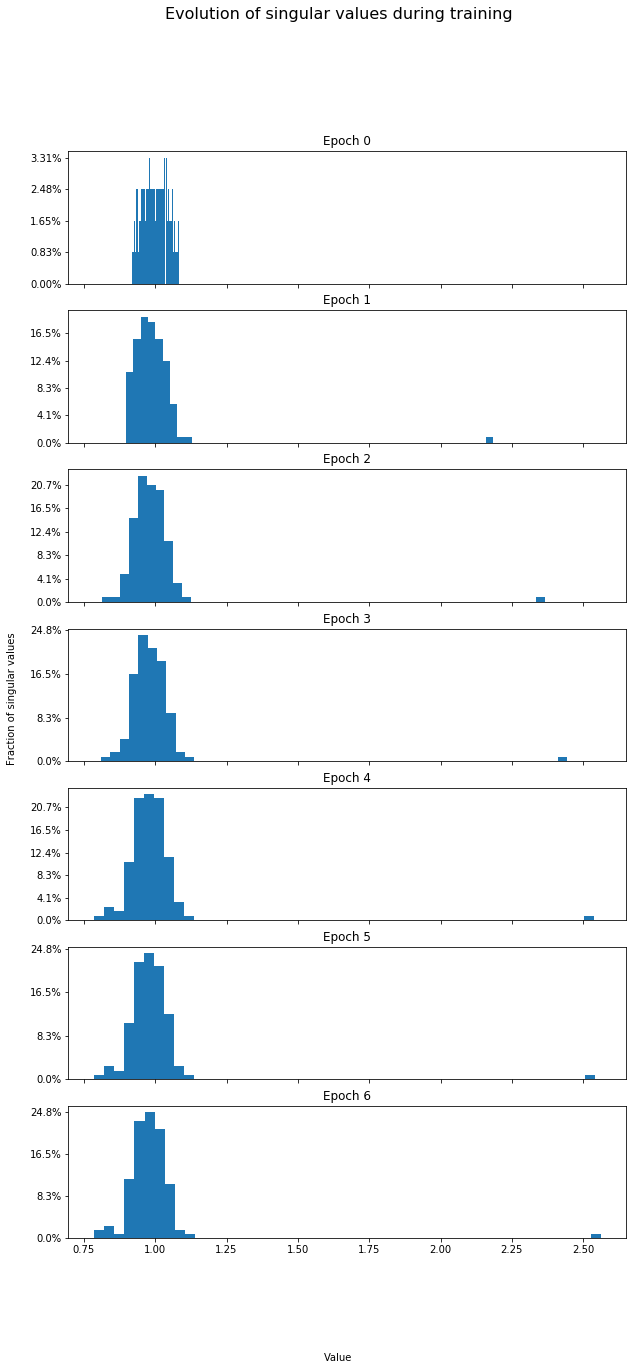

In [23]:
singular_value_distribution(s_unselected)

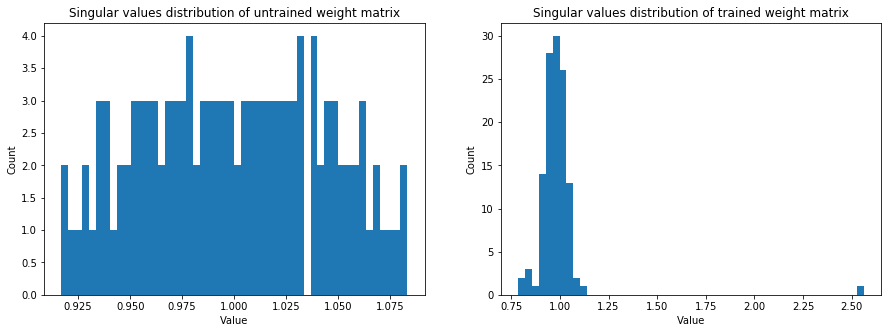

In [24]:
svd_comparison(s_unselected)

### 5. Comparing selected and unselected weight vectors

In [25]:
def selection_comparison(s1, s2):
    final_svs = s1[-1]
    s_filtered = final_svs[final_svs < 1.2]
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    hist = axs[0].hist(s_filtered, bins=50)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Final singular values distribution of selected neurons (subset)")
    final_svs = s2[-1]
    s_filtered = final_svs[final_svs < 1.2]
    hist = axs[1].hist(s_filtered, bins=50)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Final singular values distribution of unselected neurons (subset)")
    plt.show()

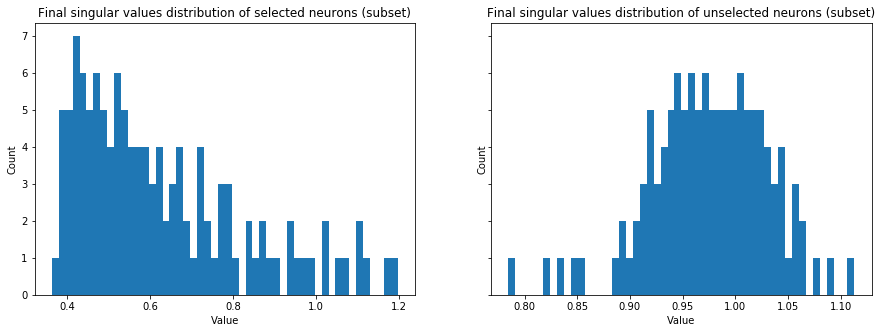

In [26]:
selection_comparison(s_selected, s_unselected)

### Title: Changeme

In [178]:
def plot_reconstruction_error(s, num_classes=10):
    epochs = s.shape[0]
    squared_s = s**2
    fig, axs = plt.subplots(epochs, 2, figsize=(14, 20), sharex=True)

    for epoch in range(epochs):
        s_epoch = squared_s[epoch]
        res = np.array([s_epoch[i:].sum() for i in range(s_epoch.size+1)])
        diff = res[1:] - res[:-1]
        axs[epoch][0].plot(res)
        axs[epoch][0].axvline(num_classes+1, color='red', linestyle='-.', linewidth=1.0, label="Number of classes")
        axs[epoch][0].set_ylabel("RE")
        axs[epoch][0].set_title(f"Epoch {epoch}: RE plot")
        axs[epoch][1].plot(diff)
        axs[epoch][1].axvline(num_classes+1, color='red', linestyle='-.', linewidth=1.0, label="Number of classes")
        axs[epoch][1].set_ylabel("Differentiated RE")
        axs[epoch][1].set_title(f"Epoch {epoch}: Differentiated RE plot")

    fig.suptitle("Reconstruction error (RE) when performing a low-rank approximation", fontsize=16)
    fig.text(0.5, 0.04, 'Rank of approximation', ha='center')

    plt.show()

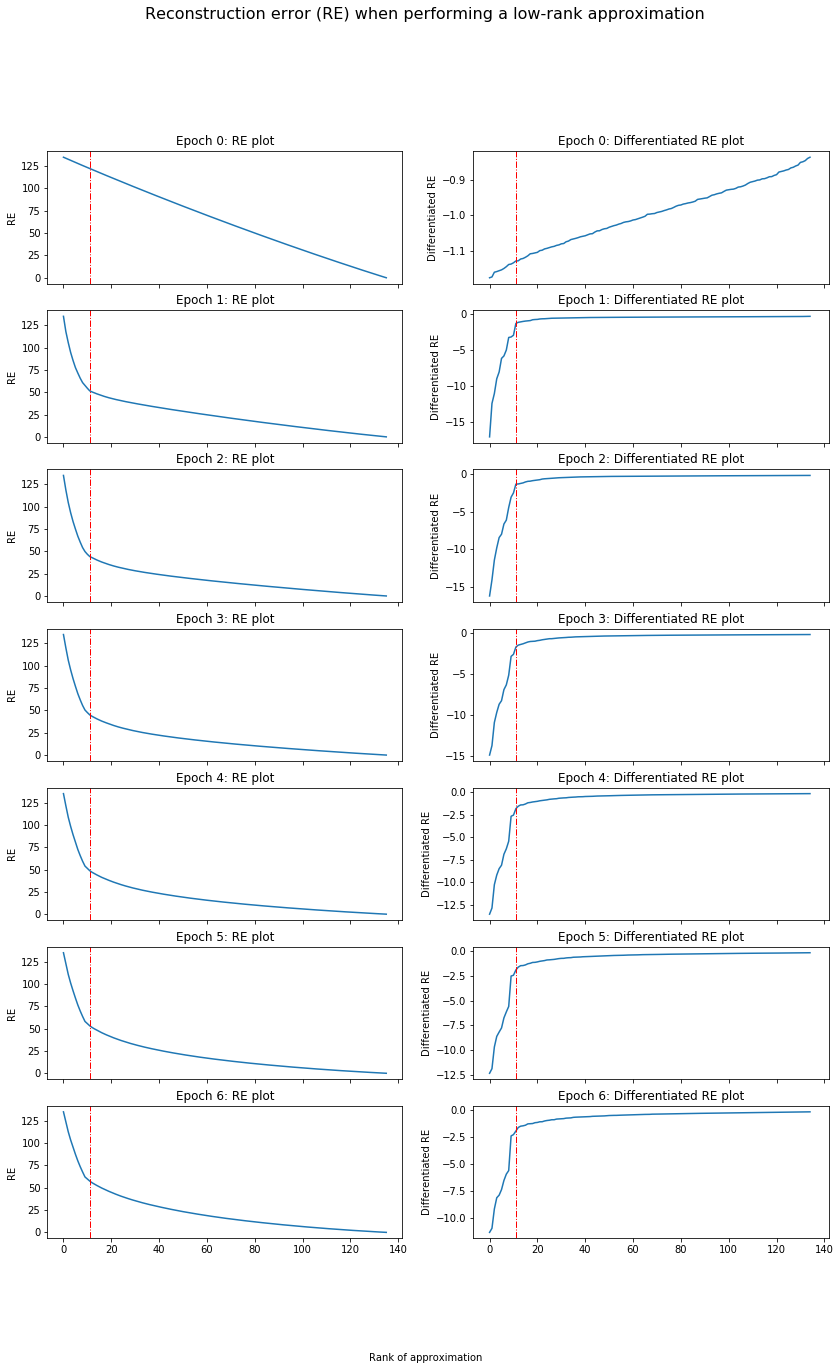

In [179]:
res = plot_reconstruction_error(s_selected)

# Experiments (remove)

In [186]:
def low_rank_approximation(u, b, rank=10):
    A = u[:, :rank]
    X, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
    approximations = A @ X
    return X, residuals, approximations

In [187]:
selected_b = w[0, selected_neurons, :].numpy().T
unselected_b = w[0, unselected_neurons, :].numpy().T
X, residuals, approximations = low_rank_approximation(u_selected[-1], selected_b)

In [192]:
def compare_residuals(u, b1, b2, rank=10):
    _, residuals1, _ = low_rank_approximation(u, b1, rank)
    _, residuals2, _ = low_rank_approximation(u, b2, rank)

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 10))
    axs[0].hist(residuals1, bins=50)
    axs[1].hist(residuals2, bins=50)
    plt.show()

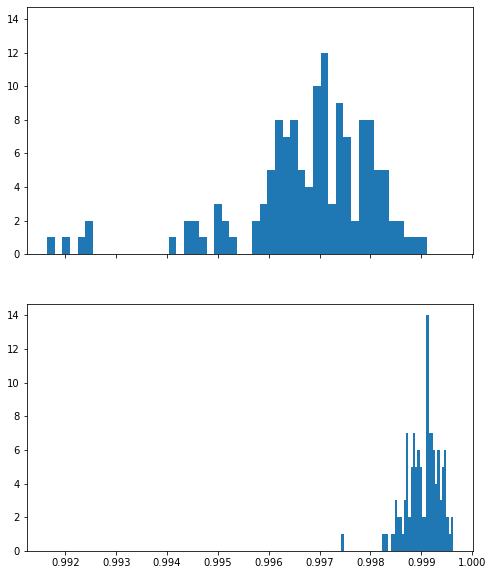

In [199]:
selected_b = w[0, selected_neurons, :].numpy().T
unselected_b = w[0, unselected_neurons, :].numpy().T
compare_residuals(u_selected[-1], selected_b, unselected_b, 15)

# Experiment: project on subspace obtained with different seed

### New part: Title

In [34]:
train_batch_size = 64
test_batch_size = 1000
trainloader, testloader, _ = get_cifar(train_batch_size, test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
from torch.nn import CrossEntropyLoss

In [36]:
accuracy = s.evaluate_model(testloader, CrossEntropyLoss(), 0)


Test set: Average loss: 2.3029, Accuracy:   1030/ 10000 (10%)



In [37]:
len(unselected_neurons)

121

In [38]:
from experiment import Experiment

In [39]:
selected_model = s.sub_network(0, layer, unselected_neurons)

In [40]:
e = Experiment(selected_model, CrossEntropyLoss(), None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 2.3011, Accuracy:   1064/ 10000 (11%)



In [41]:
selected_model = s.sub_network(-1, layer, unselected_neurons)

In [42]:
e = Experiment(selected_model, CrossEntropyLoss(), None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 1.5814, Accuracy:   6713/ 10000 (67%)



In [43]:
trained_weights = getattr(e.model, layer).get_weights().numpy().T

In [44]:
trained_weights.shape

(16384, 256)

In [45]:
A = u_selected[-1, :, :20]
b = trained_weights
r = np.linalg.lstsq(A, b)
X = r[0]
projections = A @ X
print(projections.shape)

/home/julien/anaconda3/envs/nn-pruning/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


(16384, 256)


In [46]:
new_weights = projections.T

In [47]:
getattr(e.model, layer).weight.data = torch.Tensor(new_weights)  # Problem with device

In [48]:
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 1.8483, Accuracy:   6591/ 10000 (66%)



In [55]:
b.shape

(16384, 256)

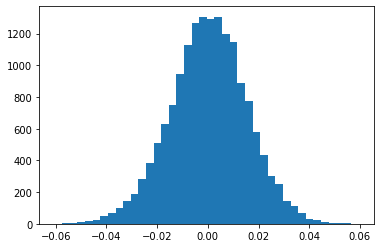

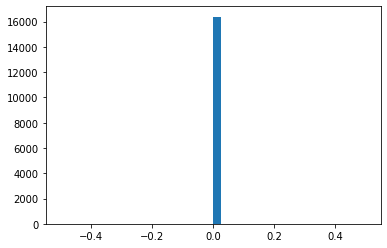

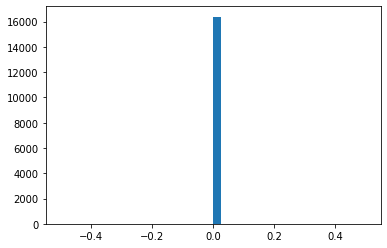

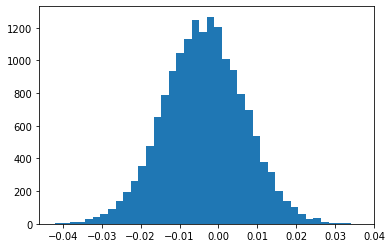

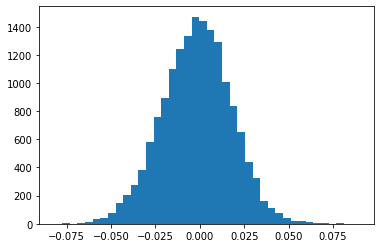

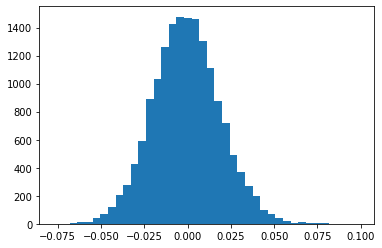

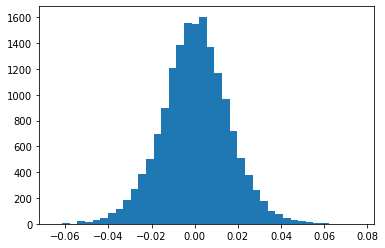

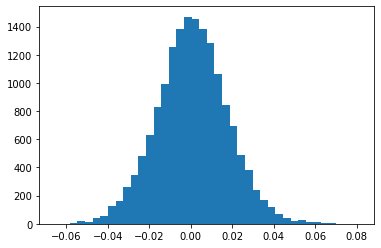

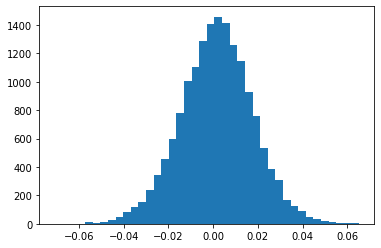

In [81]:
for i in range(9):
    plt.hist(new_weights[i], bins=40)
    plt.show()

In [82]:
inner_products = np.load(ip_paths[layer])[:epochs]

In [89]:
ips = inner_products[-1][selected_neurons][:, selected_neurons]

In [94]:
len(selected_neurons)

135

In [103]:
unique_ips = np.tril(ips, -1).flatten()

In [105]:
unique_ips = unique_ips[unique_ips != 0.]

In [106]:
len(unique_ips)

9045

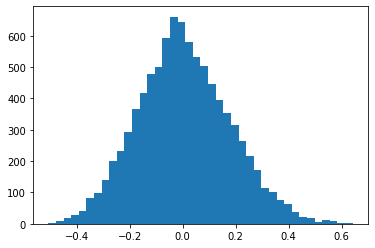

In [107]:
plt.hist(unique_ips, bins=40)
plt.show()

In [30]:
from scipy.linalg import subspace_angles